In [2]:
import sys, os
import pathlib
import time
import importlib
import joblib
import pickle
import shutil
from tqdm import tqdm

import numpy as np

from scipy.linalg import null_space
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import cv2

In [3]:
%load_ext autoreload
%autoreload 2

if not os.path.abspath("../") in sys.path:
    sys.path.append(os.path.abspath("../"))
    sys.path.append(os.path.abspath("../src"))

from src import normalization
from src import Camera, metashape_Camera
from src import camera_correspondence, FF_mat, epipole_angle, pair_and_key_gen, coll_dict_gen, pair_pt_gen
from src import FR_check, coordinate_dict_gen
from src import min_dist, tri, TDlines_gen, reprojection_gen, gen_support_dict, gen_support
from src import all_D, frag_list_fraged, all_sep

## パイプライン

In [4]:
def all_prop(occ, noise, ind, img_num):
    if noise == "0mm":
        view_mat_name = "q_e"
    elif noise == "1mm":
        view_mat_name = "q_e_noise_1mm"
    elif noise == "3mm":
        view_mat_name = "q_e_noise_3mm"
    
    cam_list = [Camera(i) for i in range(img_num)]
    for i in range(len(cam_list)):
        cam_list[i].img_load("images/{}/{}/{}".format(occ, individual, str(img_num)))
        cam_list[i].contour_extraction()
        cam_list[i].label_load("preprocessing/labels/{}_l/{}/{}/{}_{}_label.pickle".format(
            occ, noise, individual, individual, str(img_num)))
        cam_list[i].correspondence_contour()
        cam_list[i].para_load("view_mats/{}/view_mat_{}/{}.csv".format(view_mat_name, str(img_num), str(i)))
        kernel = np.ones((3,3),np.uint8)
    w = 5

    for cnum in range(len(cam_list)):
        sparse_mats_list = []
        for j in range(len(cam_list[cnum].contour_list)):
            new_img = np.zeros((cam_list[0].img[0].shape[0],cam_list[0].img[0].shape[1]),dtype=np.uint8)
            for i in range(len(cam_list[cnum].contour_list[j])):
                curve = cam_list[cnum].contour_list[j][i][~np.isnan(cam_list[cnum].contour_list[j][i])].reshape((-1,2)).astype(int)
                new_img[curve[:,1],curve[:,0]]=True
            dilation = cv2.dilate(new_img, kernel, iterations = w)
            new_img = csr_matrix(dilation, dtype=np.uint8)
            sparse_mats_list.append(new_img)

        cam_list[cnum].contour_img = sparse_mats_list
    # エピポール取得
    b = 20
    if img_num == 64:
        b = 30
    elif img_num == 32:
        b = 60
    elif img_num == 16:
        b = 180

    cam_pairs = camera_correspondence(cam_list,angle_upper=b / 180 * np.pi)

    epipole_dict = {i:[] for i in range(len(cam_list))}
    cam_pairs_F = {}
    for i in cam_pairs:
        epipole1, epipole2, F = FF_mat(cam_list[i[0]].A, cam_list[i[1]].A, cam_list[i[0]].Rt, cam_list[i[1]].Rt)
        epipole_dict[i[0]].append(normalization(epipole1))
        epipole_dict[i[1]].append(normalization(epipole2))
        cam_pairs_F[i] = F
    #print(len(cam_pairs))
    
    target_dir = "temp"

    shutil.rmtree(target_dir)
    os.mkdir(target_dir)
    # フラグメントのリストを作る
    for i in range(len(cam_list)):
        im_del_list = all_D(epipole_angle(i, epipole_dict, cam_list=cam_list))# im_del_list[color][contour][del_idx]
        newCon = all_sep(cam_list[i].contour_list, im_del_list)# newCon[color][fragment][coordination]
        cam_list[i].frag_list = frag_list_fraged(newCon)

    del epipole_dict
    _ = joblib.Parallel(n_jobs=-1, verbose=0)(joblib.delayed(pair_and_key_gen)(i, cam_list, cam_pairs_F) for i in cam_pairs_F)
    temp_path = pathlib.Path("temp/")
    tags_path = list(temp_path.glob("*.pair_list"))

    tags = []
    for tag_path in tags_path:
        tag_sp = tag_path.stem.split("_")
        tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
        tags.append(tag_arr)
    _ = joblib.Parallel(n_jobs=-1, verbose=0)(joblib.delayed(coll_dict_gen)(i, cam_list, cam_pairs_F) for i in tags)
    _ = joblib.Parallel(n_jobs=-1, verbose=0)(joblib.delayed(pair_pt_gen)(i) for i in tags)
    _ = joblib.Parallel(n_jobs=-1, verbose=0)(joblib.delayed(coordinate_dict_gen)(i, cam_list=cam_list) for i in tags)
    result = joblib.Parallel(n_jobs=-1,verbose=0)(joblib.delayed(TDlines_gen)(
        tag, cam_list=cam_list, cam_pairs_F=cam_pairs_F) for tag in tags)
    result = joblib.Parallel(n_jobs=-1,verbose=0)(joblib.delayed(reprojection_gen)(tag, cam_list=cam_list) for tag in tags)
    
    temp_path = pathlib.Path("temp/")
    tags_path = list(temp_path.glob("*.reprojection_dict"))

    tags = []
    for tag_path in tags_path:
        tag_sp = tag_path.stem.split("_")
        tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
        tags.append(tag_arr)
    result = joblib.Parallel(n_jobs=-1,verbose=0)(joblib.delayed(gen_support)(tag, cam_list=cam_list) for tag in tags)

In [13]:
occs = ["q_a"]
noises = ["3mm"]
individuals = ["q_1_a", "q_2_a", "q_3_a"]
img_nums = [128,64,32]
for occ in occs:
    for noise in noises:
        for individual in individuals:
            for img_num in img_nums:
                if os.path.exists(os.path.join('temps', occ, noise, individual, str(img_num)+".zip")):
                    continue
                print(occ, noise, individual, img_num)
                all_prop(occ, noise, individual, img_num)
                os.makedirs(os.path.join('temps', occ, noise, individual), exist_ok=True)
                shutil.make_archive(
                    os.path.join('temps', occ, noise, individual, str(img_num)), format='zip', root_dir='.', base_dir='temp')

q_a 3mm q_1_a 128
q_a 3mm q_1_a 64


C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\joblib\externals\loky\process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


q_a 3mm q_2_a 128
q_a 3mm q_2_a 64
q_a 3mm q_2_a 32
q_a 3mm q_3_a 128
q_a 3mm q_3_a 64
q_a 3mm q_3_a 32


In [9]:
def get_tags(temp_folder):
    tags_path = list(temp_folder.glob("*.TDlines"))

    tags = []
    for tag_path in tags_path:
        tag_sp = tag_path.stem.split("_")
        tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
        tags.append(tag_arr)
    return tags

def support_th(tags, temp_folder, sup_th):
    curve_fragment = []
    for tag in tags:
        if tag[1] == "R":
            continue

        with open(os.path.join(temp_folder, "{0}_{1}_{2}.TDlines".format(tag[0][0],tag[0][1],tag[1])), 'rb') as f:
            lines_list = pickle.load(f)

        with open(os.path.join(temp_folder, "{0}_{1}_{2}.support_dict".format(tag[0][0],tag[0][1],tag[1])), 'rb') as f:
            support_list, support_ac = pickle.load(f)
        #support_list, support_ac = support_dict[tag][0], support_dict[tag][1]
        tag_list = []
        for col, sup_col, ac_col in zip(lines_list, support_list, support_ac):
            col_curve_fragment = []
            for frag, sup, sup_ac in zip(col, sup_col, ac_col):
                if sup > sup_th:
                    frag = np.reshape(frag,(-1, 3))
                    frag = np.array([i for i,j in zip(frag, sup_ac >sup_th) if j])
                    col_curve_fragment.append(frag)
            tag_list.append(col_curve_fragment)
        curve_fragment.append(tag_list)
    return curve_fragment

def rotation_mat(angle):
    Rx = np.array([[1,0,0],
                 [0, np.cos(angle[0]), -np.sin(angle[0])],
                 [0, np.sin(angle[0]), np.cos(angle[0])]])

    Ry = np.array([[np.cos(angle[1]), 0, np.sin(angle[1])],
                 [0,1,0],
                 [-np.sin(angle[1]), 0, np.cos(angle[1])]])

    Rz = np.array([[np.cos(angle[2]), -np.sin(angle[2]), 0],
                 [np.sin(angle[2]), np.cos(angle[2]), 0],
                 [0,0,1]])
    return Rz@Rx@Ry

angle = [0, np.pi/2, np.pi/2] # pcd.rotate()
angle = [-np.pi/2, np.pi/2, np.pi/2]
R = rotation_mat(angle)
R_mirror = np.array([[-1,0,0],
                    [0,1,0],
                    [0,0,1]])


def curve_fragment_align(curve_fragment):
    cfs = [[] for i in range(8)]
    for cols in curve_fragment:
        for i in range(len(cols)):
            cfs[i] += cols[i]
    temp_cfs = []
    for i, cf_label in enumerate(cfs):
        A = [frag  for frag in cf_label if frag.size!=0]
        temp_cfs.append(A)
    cfs = temp_cfs
    cfs = [list(map(lambda x: x*10@R@R_mirror, cf_label)) for cf_label in cfs]
    return cfs

In [10]:
targz_file =pathlib.Path("temps/q_a/3mm/q_1_a/32.zip")
prefix_temp_folder = pathlib.Path("temps/q_a/3mm/q_1_a")

shutil.unpack_archive(targz_file, prefix_temp_folder)

temp =pathlib.Path("temps/q_a/3mm/q_1_a/temp")

tags = get_tags(temp)

curves = support_th(tags, temp, 0)

cfs = curve_fragment_align(curves)

In [11]:
for i in range(len(cfs)):
    print(len(cfs[i]))

34668
20973
37087
32001
24323
33780
36212
39671


In [ ]:
individuals = ["q_1_a", "q_2_a", "q_3_a"]
img_nums = [128,64,32]
for img_num in img_nums:
    for individual in individuals:
        all_prop(individual, img_num)
        shutil.make_archive('q_e_noise_1mm_temp/{}_{}'.format(individual, img_num), format='zip', root_dir='.', base_dir='temp')

In [16]:
cam_list = [Camera(i) for i in range(img_num)]
for i in range(len(cam_list)):
    cam_list[i].img_load("images/quan_equidistant/{}/{}".format(individual, str(img_num)))
    cam_list[i].contour_extraction()
    cam_list[i].label_load("preprocessing/labels/q_e_l_noise_3mm/{}/{}_{}_label.pickle".format(individual, individual, str(img_num)))
    cam_list[i].correspondence_contour()
    cam_list[i].calc_leaf_area()
    cam_list[i].para_load("view_mats/q_e_noise_3mm/view_mat_{}/{}.csv".format(str(img_num), str(i)))
    cam_list[i].occlusion_load(
        "preprocessing/labels/q_e_l_noise_3mm/{}/{}_{}_occlusion.pickle".format(individual, individual, str(img_num)))


In [17]:
def sum_occlusion(cam_list):
    return np.sum([cam.occlusion for cam in cam_list], axis=0)/len(cam_list)

In [18]:
sum_occlusion(cam_list)

array([0.10976352, 0.12068042, 0.12897283, 0.09650272, 0.13766832,
       0.1263807 , 0.11557271, 0.11726213])

In [5]:
kernel = np.ones((3,3),np.uint8)
w = 5

for cnum in range(len(cam_list)):
    sparse_mats_list = []
    for j in range(len(cam_list[cnum].contour_list)):
        new_img = np.zeros((cam_list[0].img[0].shape[0],cam_list[0].img[0].shape[1]),dtype=np.uint8)
        for i in range(len(cam_list[cnum].contour_list[j])):
            curve = cam_list[cnum].contour_list[j][i][~np.isnan(cam_list[cnum].contour_list[j][i])].reshape((-1,2)).astype(int)
            new_img[curve[:,1],curve[:,0]]=True
        dilation = cv2.dilate(new_img, kernel, iterations = w)
        new_img = csr_matrix(dilation, dtype=np.uint8)
        sparse_mats_list.append(new_img)
        
    cam_list[cnum].contour_img = sparse_mats_list

In [6]:
# エピポール取得
b = 20
if img_num == 64:
    b = 30
elif img_num == 32:
    b = 60
elif img_num == 16:
    b = 180

cam_pairs = camera_correspondence(cam_list,angle_upper=b / 180 * np.pi)

epipole_dict = {i:[] for i in range(len(cam_list))}
cam_pairs_F = {}
for i in cam_pairs:
    epipole1, epipole2, F = FF_mat(cam_list[i[0]].A, cam_list[i[1]].A, cam_list[i[0]].Rt, cam_list[i[1]].Rt)
    epipole_dict[i[0]].append(normalization(epipole1))
    epipole_dict[i[1]].append(normalization(epipole2))
    cam_pairs_F[i] = F
print(len(cam_pairs))

416


In [7]:
import os
import shutil
target_dir = "temp"

shutil.rmtree(target_dir)
os.mkdir(target_dir)

In [8]:
# フラグメントのリストを作る
for i in range(len(cam_list)):
    im_del_list = all_D(epipole_angle(i, epipole_dict, cam_list=cam_list))# im_del_list[color][contour][del_idx]
    newCon = all_sep(cam_list[i].contour_list, im_del_list)# newCon[color][fragment][coordination]
    cam_list[i].frag_list = frag_list_fraged(newCon)

del epipole_dict

C:\home\study\git_test\curve_sketch\src\epipolar.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return list(map(lambda y: (y - min(B)) / (max(B) - min(B)), B))


In [9]:
#cnum = 4
#new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)
#
#for j in range(len(cam_list[cnum].frag_list)):
#    for i in range(len(cam_list[cnum].frag_list[j])):
#        curve = cam_list[cnum].frag_list[j][i][~np.isnan(cam_list[cnum].frag_list[j][i])].reshape((-1,2)).astype(int)
#        new_img[curve[:,1],curve[:,0]]=True

In [10]:
#%matplotlib inline
#fig = plt.figure(figsize = (20, 20))
#fig.patch.set_alpha(0.)
## 3DAxesを追加
#ax = fig.add_subplot(111)
#plt.imshow(new_img)

## ペア生成

In [11]:
%%time
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(pair_and_key_gen)(i, cam_list, cam_pairs_F) for i in cam_pairs_F)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Wall time: 15min 36s


In [12]:
temp_path = pathlib.Path("temp/")
tags_path = list(temp_path.glob("*.pair_list"))

tags = []
for tag_path in tags_path:
    tag_sp = tag_path.stem.split("_")
    tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
    tags.append(tag_arr)

In [13]:
%%time
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(coll_dict_gen)(i, cam_list, cam_pairs_F) for i in tags)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Wall time: 16min 4s


In [14]:
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(pair_pt_gen)(i) for i in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [15]:
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(coordinate_dict_gen)(i, cam_list=cam_list) for i in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

## 3次元再構築

In [16]:
result = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(TDlines_gen)(
    tag, cam_list=cam_list, cam_pairs_F=cam_pairs_F) for tag in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 2

In [17]:
%%time
result = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(reprojection_gen)(tag, cam_list=cam_list) for tag in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Wall time: 21min 20s


In [18]:
temp_path = pathlib.Path("temp/")
tags_path = list(temp_path.glob("*.reprojection_dict"))

tags = []
for tag_path in tags_path:
    tag_sp = tag_path.stem.split("_")
    tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
    tags.append(tag_arr)

In [19]:
result = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(gen_support)(tag, cam_list=cam_list) for tag in tags)
#4.1min finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 50.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 58.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 6

In [38]:
sup_th = 40# サポート数
curve_fragment = []
for tag in tags:
    if tag[1] == "R":
        continue
    
    with open(r"temp/{0}_{1}_{2}.TDlines".format(tag[0][0],tag[0][1],tag[1]), 'rb') as f:
        lines_list = pickle.load(f)
    #lines_list = TDlines[tag]
    
    with open(r"temp/{0}_{1}_{2}.support_dict".format(tag[0][0],tag[0][1],tag[1]), 'rb') as f:
        support_list, support_ac = pickle.load(f)
    #support_list, support_ac = support_dict[tag][0], support_dict[tag][1]
    tag_list = []
    for col, sup_col, ac_col in zip(lines_list, support_list, support_ac):
        col_curve_fragment = []
        for frag, sup, sup_ac in zip(col, sup_col, ac_col):
            if sup > sup_th:
                frag = np.reshape(frag,(-1, 3))
                frag = np.array([i for i,j in zip(frag, sup_ac >sup_th) if j])
                col_curve_fragment.append(frag)
        tag_list.append(col_curve_fragment)
    curve_fragment.append(tag_list)

In [39]:
cfs = [[],[],[],[],[],[],[],[],[]]
for cols in curve_fragment:
    for i in range(len(cols)):
        if i == 0:
            cfs[0] += cols[i]
        if i == 1:
            cfs[1] += cols[i]
        if i == 2:
            cfs[2] += cols[i]
        if i == 3:
            cfs[3] += cols[i]
        if i == 4:
            cfs[4] += cols[i]
        if i == 5:
            cfs[5] += cols[i]
        if i == 6:
            cfs[6] += cols[i]
        if i == 7:
            cfs[7] += cols[i]
        if i == 8:
            cfs[8] += cols[i]

In [43]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if j % 1 != 0:
                j+=1
                continue
            j+=1
            if frag.size < 10:
                continue
            if i != 4:
                continue
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            except UnboundLocalError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            ax.plot(new[0], new[2], new[1],"-",color=c)


In [44]:
%matplotlib notebook

<IPython.core.display.Javascript object>


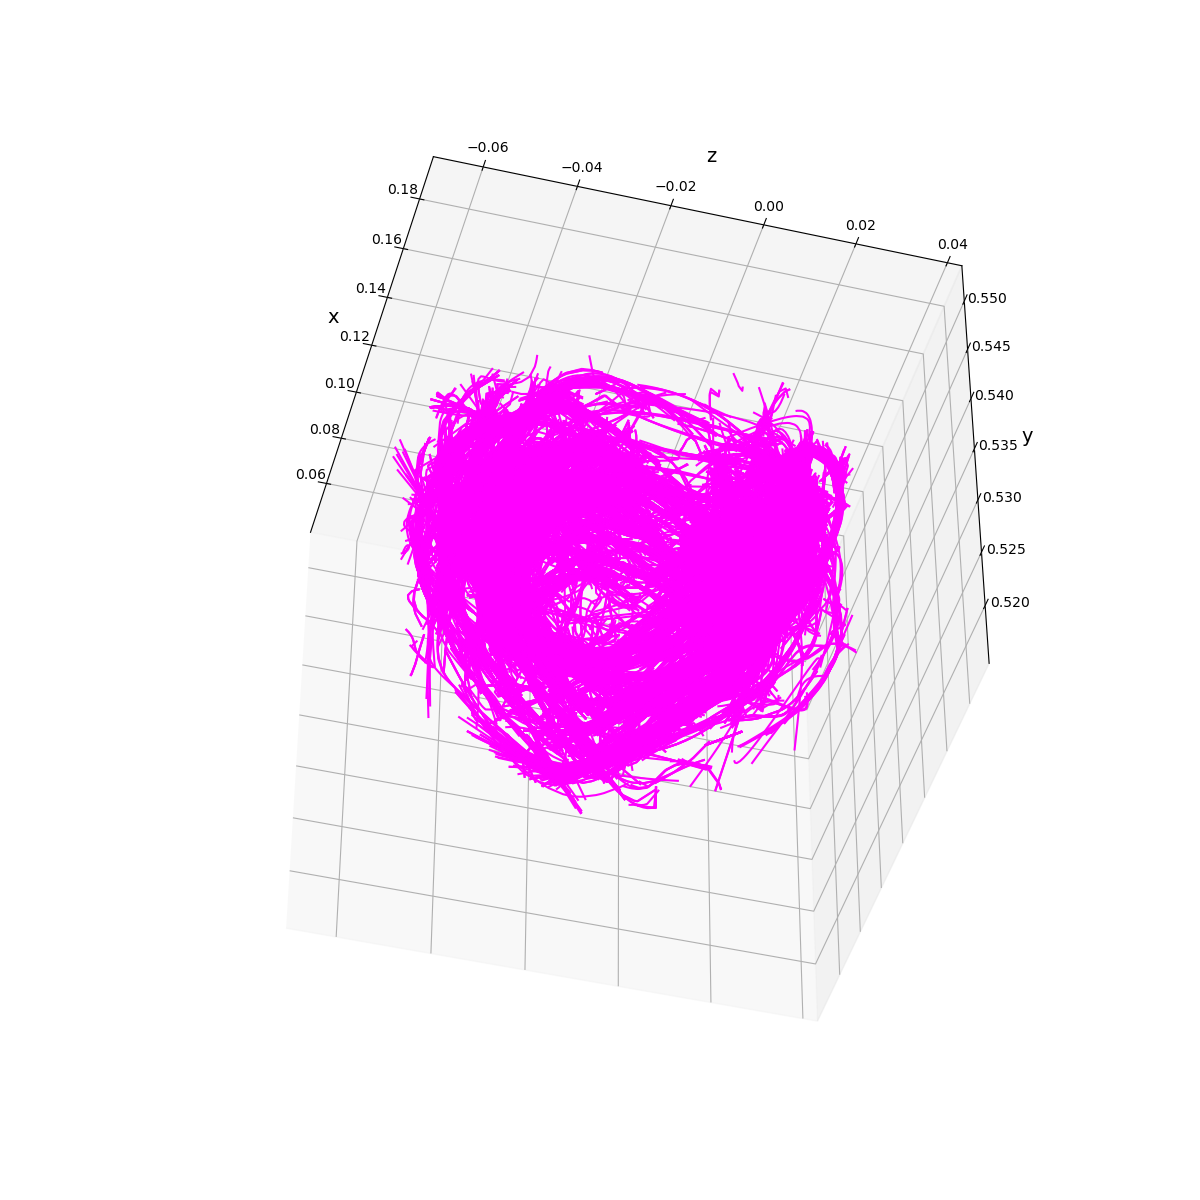

In [45]:
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))
#ax.set_xticks(np.arange(-4,4,1))
#ax.set_yticks(np.arange(-4,4,1))
#ax.set_zticks(np.arange(-2,9,1))

plot_graph()

In [25]:
import itertools

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [46]:
import pickle
os.makedirs("postprocessing/curves_by/q_curves/q_e_noise_3mm/{}/".format(individual), exist_ok=True)
with open("postprocessing/curves_by/q_curves/q_e_noise_3mm/{}/{}_b{}_s{}_lmin40_lmax_100_o15_w{}.curves".format(
    individual, str(img_num), str(b), str(sup_th), str(w)),"wb") as f:
    pickle.dump(curve_fragment, f)

flatten_curve_frag = np.array(list(itertools.chain.from_iterable(_curve_fragment)))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)

o3d.visualization.draw_geometries([pcd])

from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
### 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

### 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

def plot_graph():
    i = 0
    for c_f in curve_fragment:
        for frag in c_f:
            if frag.size == 0:
                continue
            #print(frag)
            
            if i%100 == 0:
                x = frag[:,0]
                y = frag[:,1]
                z = frag[:,2]
                data = [x,y,z]
                try:
                    tck, u= interpolate.splprep(data, k=3)
                except ValueError:
                    pass
                except TypeError:
                    pass
                new = interpolate.splev(u, tck, der=0)

                ax.plot(new[0], new[2], new[1],"-")
                    #ax.plot(x, z, y,"-")
            i += 1

def plt_graph3d(angle):
    ax.view_init(azim=angle*5)
    
### アニメーションを作成
ani = FuncAnimation(
    fig,
    func=plt_graph3d,
    frames=72,
    init_func=plot_graph,
    interval=200
)

### imagemagickで作成したアニメーションをGIFで書き出す
ani.save("48_rolling.gif", writer="pillow", savefig_kwargs={'transparent': True, 'facecolor': 'none'})
#ani.save('48_anim.mp4', writer="ffmpeg", savefig_kwargs={'transparent': True, 'facecolor': 'none'})